In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
import spacy
from sklearn.model_selection import train_test_split
from preprocess_texts import generate_vocabulary, process_data
from attention_text_classifier import Attention_Classification_Model

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
imdb_dataset = load_dataset("imdb")

train_data = imdb_dataset["train"]
test_data = imdb_dataset["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_data, val_data = train_test_split(train_data, test_size = 0.2,stratify = train_data['label'])

In [ ]:
word_to_idx = generate_vocabulary(train_data, nlp)

In [ ]:
train_texts, train_labels = process_data(train_data, word_to_idx)
val_texts, val_labels = process_data(val_data, word_to_idx)
test_texts, test_labels = process_data(test_data, word_to_idx)

train_texts = torch.LongTensor(train_texts)
train_labels = torch.FloatTensor(train_labels)
test_texts = torch.LongTensor(test_texts)
test_labels = torch.FloatTensor(test_labels)

In [ ]:
batch_size = 16
train_data = TensorDataset(train_texts, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_texts, torch.FloatTensor(val_labels))
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)


test_data = TensorDataset(test_texts, test_labels)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
vocab_size = len(word_to_idx)
embed_size = 256
hidden_size = 128
model = Attention_Classification_Model(vocab_size, embed_size, hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 2e-4)
model.to(device)

Attention_Classification_Model(
  (embedding): Embedding(108484, 256)
  (attention): Attention(
    (Q): Linear(in_features=256, out_features=128, bias=True)
    (K): Linear(in_features=256, out_features=128, bias=True)
    (V): Linear(in_features=256, out_features=128, bias=True)
    (softmax): Softmax(dim=1)
  )
  (add_norm): AddNorm(
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
num_epochs = 8
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=3, num_training_steps=total_steps)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

epoch_train_loss = []
epoch_val_loss = []
epoch_train_accuracy = []
epoch_val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        predicted = (outputs >= 0.5).squeeze().long()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}, Training Accuracy: {100 * train_accuracy:.2f}%")

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_labels).item()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            predicted = (val_outputs >= 0.5).squeeze().long()
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {100 * val_accuracy:.2f}%")

    epoch_train_loss.append(avg_train_loss)
    epoch_val_loss.append(avg_val_loss)
    epoch_train_accuracy.append(train_accuracy)
    epoch_val_accuracy.append(val_accuracy)

Epoch [1/8], Average Training Loss: 0.6548, Training Accuracy: 60.05%
Epoch [1/8], Validation Loss: 0.5934, Validation Accuracy: 68.98%
Epoch [2/8], Average Training Loss: 0.5238, Training Accuracy: 74.09%
Epoch [2/8], Validation Loss: 0.4717, Validation Accuracy: 77.64%
Epoch [3/8], Average Training Loss: 0.4442, Training Accuracy: 79.62%
Epoch [3/8], Validation Loss: 0.4334, Validation Accuracy: 79.96%
Epoch [4/8], Average Training Loss: 0.3937, Training Accuracy: 82.36%
Epoch [4/8], Validation Loss: 0.4168, Validation Accuracy: 81.82%
Epoch [5/8], Average Training Loss: 0.3547, Training Accuracy: 84.53%
Epoch [5/8], Validation Loss: 0.3991, Validation Accuracy: 82.28%
Epoch [6/8], Average Training Loss: 0.3211, Training Accuracy: 86.64%
Epoch [6/8], Validation Loss: 0.3965, Validation Accuracy: 83.16%
Epoch [7/8], Average Training Loss: 0.2959, Training Accuracy: 88.07%
Epoch [7/8], Validation Loss: 0.4007, Validation Accuracy: 82.86%
Epoch [8/8], Average Training Loss: 0.2771, Trai

In [ ]:
model.eval()
correct = 0
total = 0
y_pred_list = []
output_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device))
        output_probs.extend(outputs.detach().cpu().squeeze().long().tolist())
        predicted = (outputs >= 0.5).squeeze().long()
        y_pred_list.extend(predicted.detach().cpu().tolist())  # Append predicted labels to the list
        total += labels.size(0)
        correct += (predicted.detach().cpu() == labels.long()).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy:.2f}%")

Accuracy on the test set: 81.92%


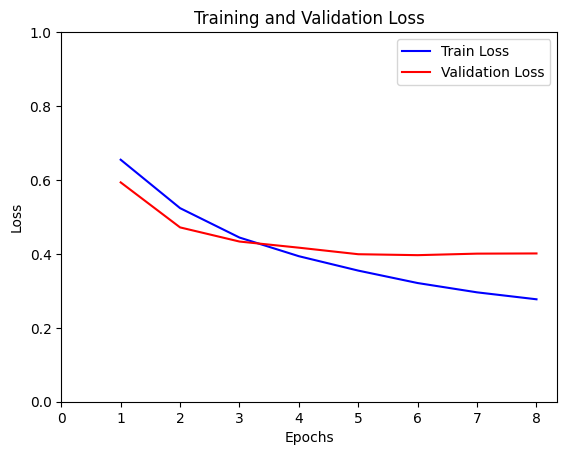

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(epoch_train_loss) + 1)
plt.plot(epochs, epoch_train_loss, 'b', label='Train Loss')
plt.plot(epochs, epoch_val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(left=0)
plt.ylim(bottom=0,top = 1)
plt.legend()
plt.show()

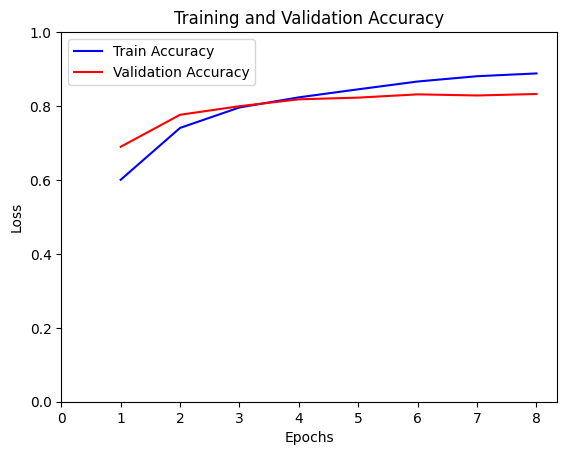

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(epoch_train_accuracy) + 1)
plt.plot(epochs, epoch_train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, epoch_val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(left=0)
plt.ylim(bottom=0,top = 1)
plt.legend()
plt.show()

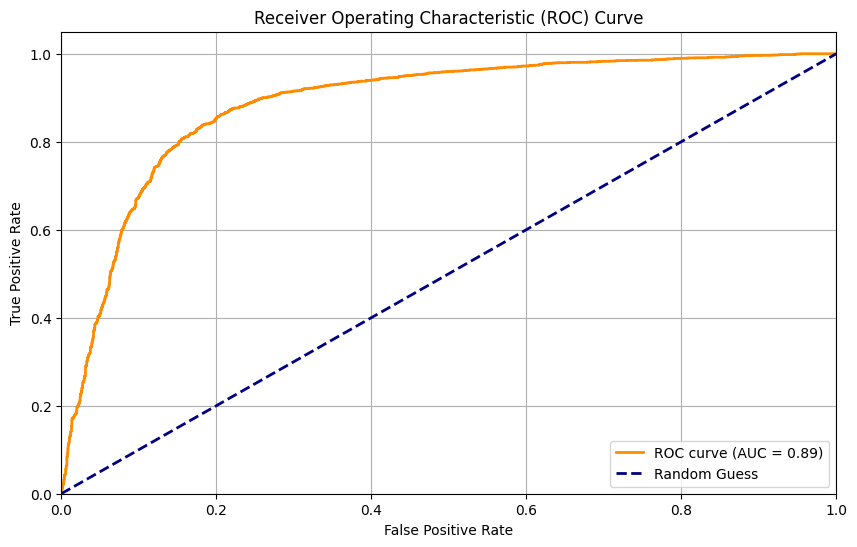

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

model.eval()
true_labels = []
predicted_probs = []

with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        val_probs = torch.softmax(val_outputs, dim=0)

        true_labels.extend(val_labels.cpu().numpy())
        predicted_probs.extend(val_probs.cpu().numpy())

true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()